# Classification Image

## Importing Module

In [1]:
import os
import random
import zipfile
import urllib.request
import tensorflow as tf
import matplotlib.image as mpimg


from pathlib import Path
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## PROBLEM A2
---
- Build a Neural Network Model for Horse or Human Dataset.
The test will expect it to classify binary classes.
Your input layer should accept `150x150` with 3 bytes color as the input shape.
Don't use lambda layers in your model.

- The dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
Desired accuracy and validation_accuracy > `83%`

### Prepare Data

In [2]:
data_url_1 = 'https://github.com/dicodingacademy/assets/releases/download/release-horse-or-human/horse-or-human.zip'
data_url_2 = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/validation-horse-or-human.zip'

train_dir = Path('data/horse-or-human')
val_dir = Path('data/validation-horse-or-human')


list_files = {
    'file_1' : ['horse-or-human.zip', data_url_1, train_dir],
    'file_2' : ['validation-horse-or-human.zip', data_url_2, val_dir]
}

#### Download and Extract Data

In [3]:
for data_file in list_files.values():
  try:
    if os.path.isfile(data_file[0]) == False:
      urllib.request.urlretrieve(data_file[1], data_file[0])
      zip_ref = zipfile.ZipFile(data_file[0], 'r')
      zip_ref.extractall(data_file[2])
      zip_ref.close()
      print(f'{data_file[0]} Download and Extract finished')
    else:
      print(f'{data_file[0]} already exist')
  except ValueError as e:
    print(e)

horse-or-human.zip Download and Extract finished
validation-horse-or-human.zip Download and Extract finished


In [4]:
train_data_path = os.listdir(train_dir)
validation_data_path = os.listdir(val_dir)

image_count = len(list(train_dir.glob("*/*")))
print(f'Total Image in {train_dir} : {image_count}')
for i in train_data_path:
  target_path = os.path.join(train_dir, i)
  print(f'Total Train Images in {i} : {len(os.listdir(target_path))}')

print()

val_image_count = len(list(val_dir.glob("*/*")))
print(f'Total Image in {val_dir} : {val_image_count}')
for i in validation_data_path:
  target_path = os.path.join(val_dir, i)
  print(f'Total Validation Images in {i} : {len(os.listdir(target_path))}')

Total Image in data/horse-or-human : 1027
Total Train Images in horses : 500
Total Train Images in humans : 527

Total Image in data/validation-horse-or-human : 256
Total Validation Images in horses : 128
Total Validation Images in humans : 128


### Set Params

In [5]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64
desired_accuracy = 0.83

### Load Images

In [6]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

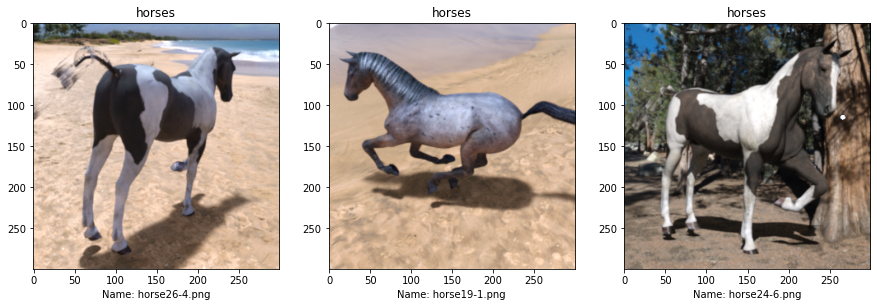

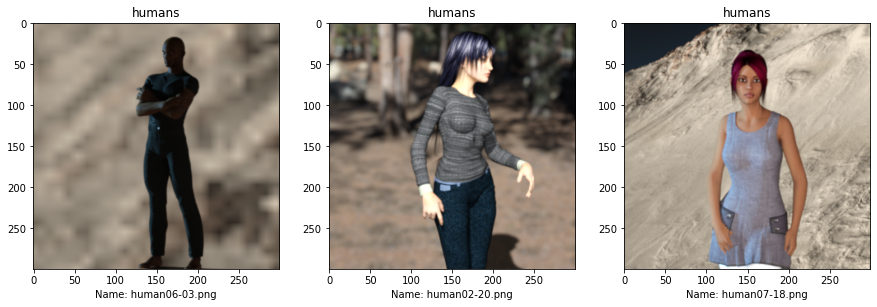

In [7]:
for dir in train_data_path:
  image_dir = os.path.join(train_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Create ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
     rescale=1./255,
     zoom_range=0.1,
     rotation_range=20,
     shear_range=0.2,
     fill_mode='nearest',
     horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary'
)


test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE//2,
    shuffle = True,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Build Model

In [9]:
def create_model():
  '''Creates a CNN with convolutional layers'''

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=IMG_SIZE + (3,)))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.7))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"])
  
  return model

In [10]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f47c2e2b390>


### Create Custom Callbakcs

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Train Model

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[custom_callback],
      validation_steps=8)

Epoch 1/20
8/8 [==============================] - 19s 739ms/step - loss: 0.6962 - accuracy: 0.5255 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 6s 750ms/step - loss: 0.6914 - accuracy: 0.5430 - val_loss: 0.6839 - val_accuracy: 0.5000
Epoch 3/20
8/8 [==============================] - 6s 704ms/step - loss: 0.6864 - accuracy: 0.5664 - val_loss: 0.6690 - val_accuracy: 0.6758
Epoch 4/20
8/8 [==============================] - 6s 762ms/step - loss: 0.6771 - accuracy: 0.5566 - val_loss: 0.5843 - val_accuracy: 0.8906
Epoch 5/20
8/8 [==============================] - 7s 874ms/step - loss: 0.6003 - accuracy: 0.6680 - val_loss: 0.6394 - val_accuracy: 0.7266
Epoch 6/20
8/8 [==============================] - 5s 667ms/step - loss: 0.3978 - accuracy: 0.8204 - val_loss: 0.8555 - val_accuracy: 0.8125
Epoch 7/20
8/8 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8470
Training accuracy was > 83.0%, stop training...
8/8 [==============

### Ploting result

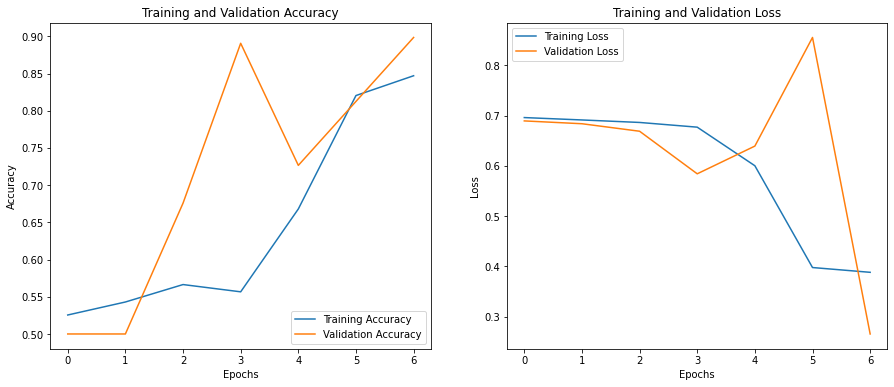

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Problem B2

- Build a classifier for the Fashion MNIST dataset.
The test will expect it to classify `10` classes.
The input shape should be 28x28 monochrome. Do not resize the data.
Your input layer should accept `(28, 28)` as the input shape.
- Don't use lambda layers in your model.
- Desired accuracy AND validation_accuracy > `83%`

### Set Params

In [14]:
IMG_SIZE = (28,28)
desired_accuracy = 0.83
BATCH_SIZE = 32

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Prepare Data

In [15]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [16]:
print(f'Total Train Image : {len(train_images)}')
print(f'Total Test Image : {len(test_images)}')

Total Train Image : 60000
Total Test Image : 10000


### Preprocessing Data

In [17]:
train_images = train_images / 255.0

test_images = test_images / 255.0

### Plot Image

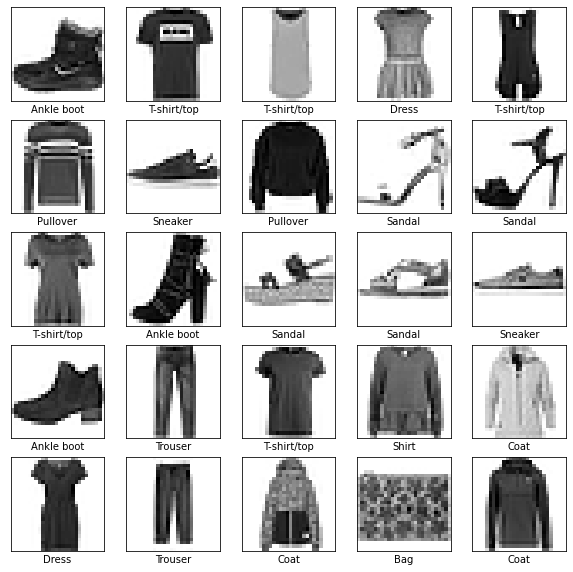

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Build Model

In [19]:
def create_model():
  '''Creates a CNN with convolutional layers'''
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=IMG_SIZE + (1,)))
  model.add(tf.keras.layers.Dense(512, activation='relu')),
  model.add(tf.keras.layers.Dense(1024, activation='relu')),
  model.add(tf.keras.layers.Dropout(0.4))

  # End with 10 Neuron Dense, activated by softmax
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])
  
  return model

In [20]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f47b058b9d0>


### Create Custom Callbakcs

In [21]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Train Model

In [22]:
model.fit(train_images,
          train_labels, 
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[custom_callback],
          steps_per_epoch=len(train_images)//BATCH_SIZE)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4816 - accuracy: 0.8242 - val_loss: 0.4386 - val_accuracy: 0.8433
Epoch 2/10
1864/1875 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8645
Training accuracy was > 83.0%, stop training...
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3713 - accuracy: 0.8644 - val_loss: 0.4281 - val_accuracy: 0.8473


# PROBLEM C2
- Create a classifier for the MNIST Handwritten digit dataset.
The test will expect it to classify `10` classes.
- Don't use lambda layers in your model.
- Desired accuracy AND validation_accuracy > `91%`

### Set Params

In [32]:
IMG_SIZE = (28,28)
desired_accuracy = 0.91

class_names = [x for x in range(10)]

### Prepare Data

In [33]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [34]:
print(f'Total Train Image : {len(train_images)}')
print(f'Total Test Image : {len(test_images)}')

Total Train Image : 60000
Total Test Image : 10000


### Preprocessing Data

In [35]:
train_images = train_images / 255.0

test_images = test_images / 255.0

### Plot Image

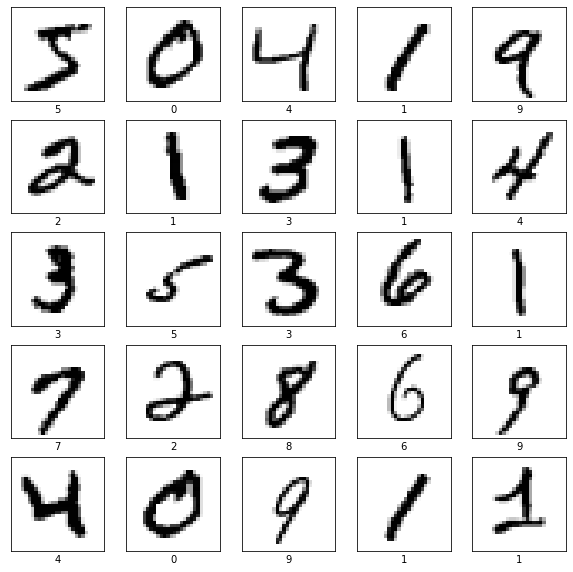

In [36]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Build Model

In [37]:
def create_model():
  '''Creates a CNN with convolutional layers'''
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=IMG_SIZE + (1,)))
  model.add(tf.keras.layers.Dense(512, activation='relu')),
  model.add(tf.keras.layers.Dense(1024, activation='relu')),
  model.add(tf.keras.layers.Dropout(0.4))

  # End with 10 Neuron Dense, activated by softmax
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])
  
  return model

In [38]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f47422bc210>


### Create Custom Callbakcs

In [39]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Train Model

In [40]:
model.fit(train_images,
          train_labels, 
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[custom_callback],
          steps_per_epoch=len(train_images)//BATCH_SIZE)

Epoch 1/10
1856/1875 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9401
Training accuracy was > 91.0%, stop training...
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1967 - accuracy: 0.9404 - val_loss: 0.0973 - val_accuracy: 0.9695
